# Telco Customer Churn – Day 11
## Model Comparison & Business Impact

> ⚠️ **Note for reviewers**
>
> This notebook is a **direct continuation of Day 10**
> (`day10_telco_churn_eda_baseline.ipynb`).
>
> It starts from the same dataset, preprocessing pipeline,
> and baseline Logistic Regression model, and extends the analysis
> with advanced models and business-focused evaluation.


In [1]:
import os

In [2]:
import glob

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split

In [90]:
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)

In [8]:
from sklearn.compose import ColumnTransformer

In [9]:
from sklearn.pipeline import Pipeline

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
from sklearn.impute import SimpleImputer

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [15]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
df.shape

(7043, 21)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [18]:
missing = df.isna().sum().sort_values(ascending = False)

In [19]:
missing = missing[missing > 0]

In [20]:
missing.head(20)

Series([], dtype: int64)

In [21]:
target_counts = df['Churn'].value_counts(dropna=False)

In [22]:
target_counts

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [23]:
(target_counts / len(df)).round(4)

Churn
No     0.7346
Yes    0.2654
Name: count, dtype: float64

In [24]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'] , errors = 'coerce')

In [25]:
df['TotalCharges'].isna().sum()

np.int64(11)

In [26]:
id_cols = [c for c in df.columns if 'id' in c.lower()]

In [27]:
id_cols

['customerID']

In [28]:
drop_cols = []

In [29]:
if 'customerID' in df.columns:
    drop_cols.append('customerID')

In [30]:
df_model = df.drop(columns = drop_cols, errors='ignore').copy()

In [31]:
df_model.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [32]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [33]:
y = df_model['Churn'].map({'Yes':1, 'No': 0})

In [34]:
X = df_model.drop(columns = ['Churn'])

In [35]:
y.value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [36]:
num_cols = X.select_dtypes(include = [np.number]).columns.tolist()

In [37]:
cat_cols = [c for c in X.columns if c not in num_cols]

In [38]:
print('Numerical', len(num_cols), num_cols)

Numerical 4 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [39]:
print('Categorical', len(cat_cols), cat_cols)

Categorical 15 ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


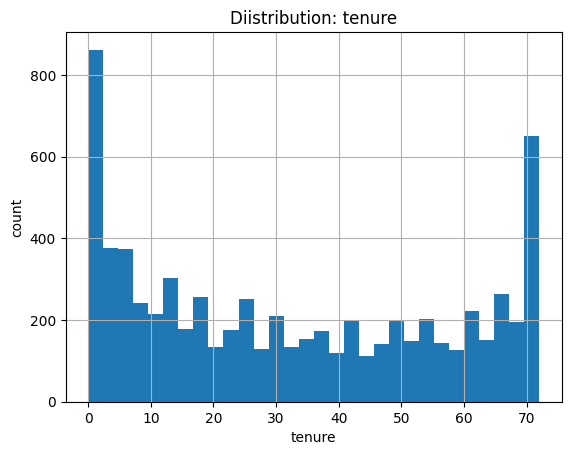

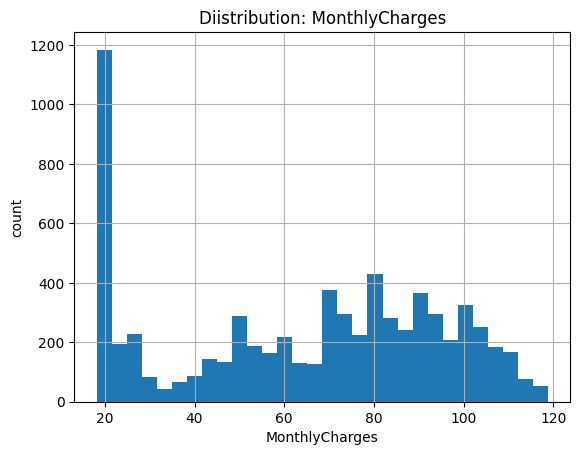

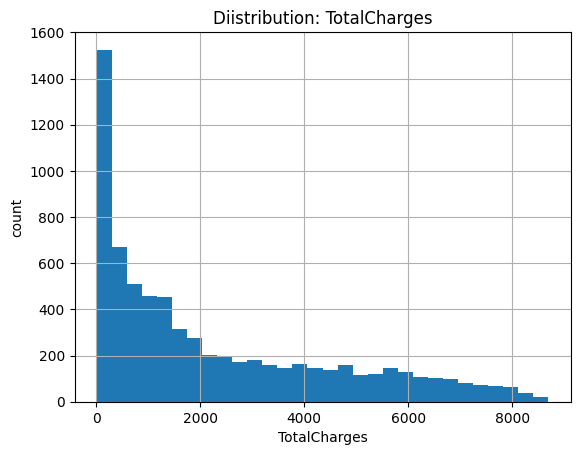

In [40]:
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    if col in X.columns:
        plt.figure()
        X[col].hist(bins = 30)
        plt.title(f"Diistribution: {col}")
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()

In [41]:
def churn_rate_by_col(df_original,col):
    tmp = df_original[[col, 'Churn']].copy()
    tmp['Churn01'] = tmp['Churn'].map({'Yes':1, 'No': 0})
    rate = tmp.groupby(col)['Churn01'].mean().sort_values(ascending=False)
    cnt = tmp[col].value_counts()
    out = pd.DataFrame({'counts': cnt, 'churn_rate': rate}).sort_values('churn_rate', ascending=False)
    return out

In [42]:
key_cats = ['Contract', 'InternetService', 'PaymentMethod', 'PapaerlessBilling', 'SeniorCitizen']

In [43]:
for col in key_cats:
    if col in df.columns:
        display(churn_rate_by_col(df,col).head(20))

,counts,churn_rate
Contract,,
Month-to-month,3875,0.427097
One year,1473,0.112695
Two year,1695,0.028319


,counts,churn_rate
InternetService,,
Fiber optic,3096,0.418928
DSL,2421,0.189591
No,1526,0.074050


,counts,churn_rate
PaymentMethod,,
Electronic check,2365,0.452854
Mailed check,1612,0.191067
Bank transfer (automatic),1544,0.167098
Credit card (automatic),1522,0.152431


,counts,churn_rate
SeniorCitizen,,
1,1142,0.416813
0,5901,0.236062


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.2, random_state = 42, stratify =y
)

In [45]:
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler',StandardScaler())
])

In [46]:
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    
])

In [47]:
preprocess = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer,num_cols),
        ('cat', categorical_transformer, cat_cols),
    ],
    remainder = 'drop'
)

In [48]:
baseline_clf = LogisticRegression(
    max_iter = 5000,
    solver = 'lbfgs',
    class_weight = 'balanced'
)

In [49]:
model = Pipeline(steps = [
    ('preprocess', preprocess),
    ('clf', baseline_clf)
])

In [50]:
model

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

In [51]:
model.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

In [52]:
y_pred = model.predict(X_test)

In [53]:
y_proba = model.predict_proba(X_test)[:,1]

In [54]:
print(classification_report(y_test,y_pred,digits = 4))

              precision    recall  f1-score   support

           0     0.9022    0.7217    0.8019      1035
           1     0.5043    0.7834    0.6136       374

    accuracy                         0.7381      1409
   macro avg     0.7032    0.7526    0.7078      1409
weighted avg     0.7966    0.7381    0.7519      1409



In [55]:
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))

ROC-AUC: 0.8413


In [56]:
cm = confusion_matrix(y_test,y_pred)

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

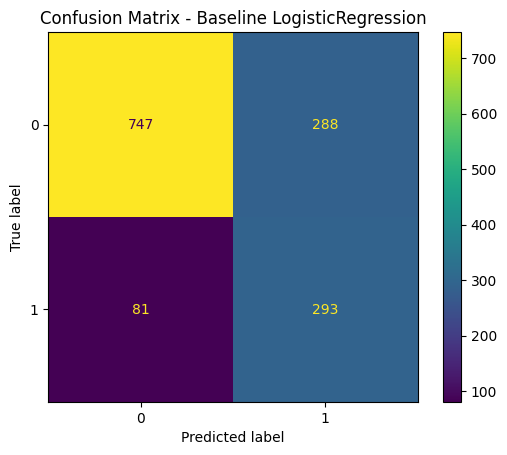

In [58]:
disp.plot()
plt.title('Confusion Matrix - Baseline LogisticRegression')
plt.show()

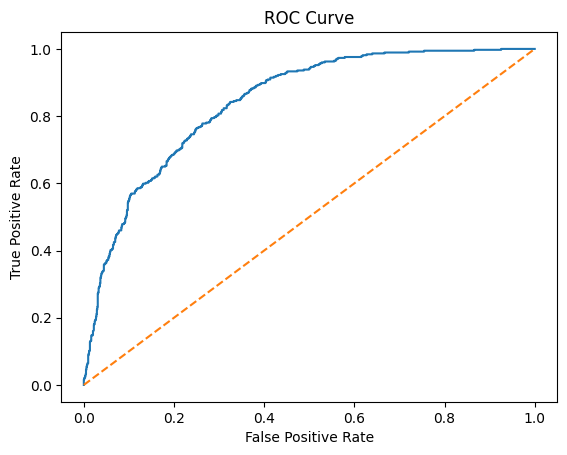

In [59]:
fpr, tpr, _ = roc_curve(y_test,y_proba)
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [60]:
#### DAY 11 START #####

In [64]:
def evaluate_classifier(model, X_test,y_test, title = 'Model'):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        scores = model.decision_function(X_test)
        y_proba = (scores - scores(min)) / (scores.max() - scores(min) + 1e-9)

    print(f"n=== {title} ===")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot(values_format = 'd')
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

    auc = roc_auc_score(y_test,y_proba)
    fpr,tpr, _ = roc_curve(y_test,y_proba)

    plt.figure()
    plt.plot(fpr,tpr,label= f"{title} (AUC = {auc:.4f}) " )
    plt.plot([0,1], [0,1], linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{title} - ROC Curve")
    plt.legend()
    plt.show()
    return {"cm":cm, "auc":auc}
        

n=== Logistic Regression (Baseline) ===
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



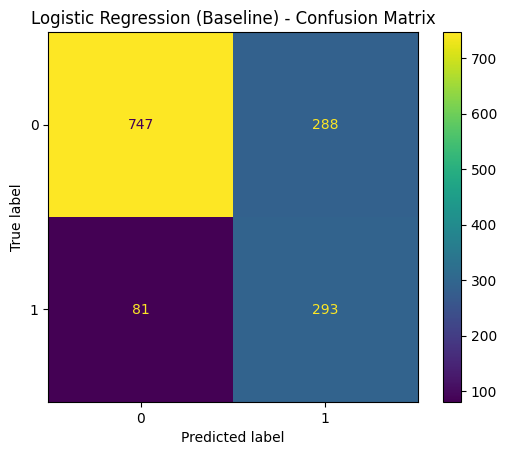

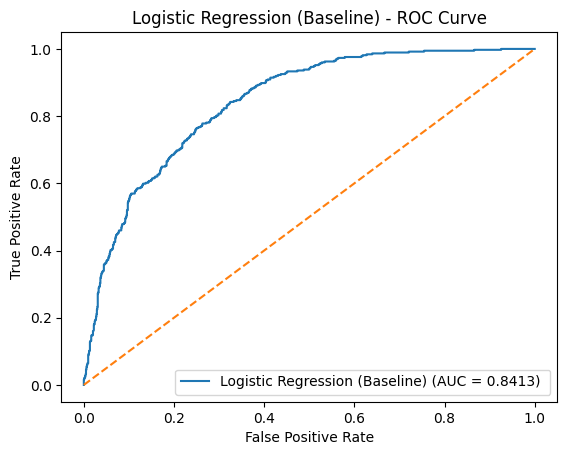

In [66]:
baseline_results = evaluate_classifier(model, X_test, y_test, title = 'Logistic Regression (Baseline)')

In [68]:
from xgboost import XGBClassifier

In [71]:
xgb_clf = XGBClassifier(
    n_estimators = 400,
    max_depth = 4,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 1.0,
    random_state = 42,
    eval_metric = 'logloss'
)

In [73]:
xgb_model = Pipeline(steps = [
    ('preprocess', preprocess),
    ('clf', xgb_clf)
])

In [74]:
xgb_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

n=== XGBoost ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



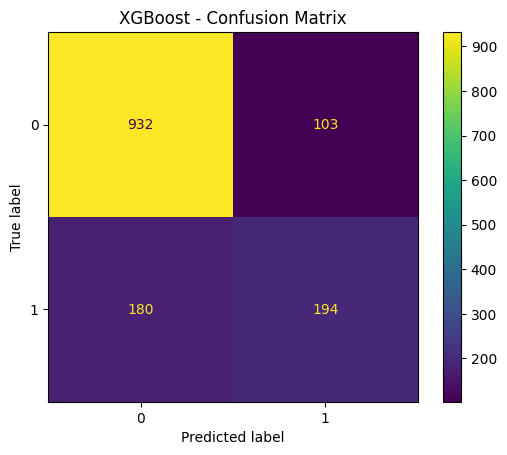

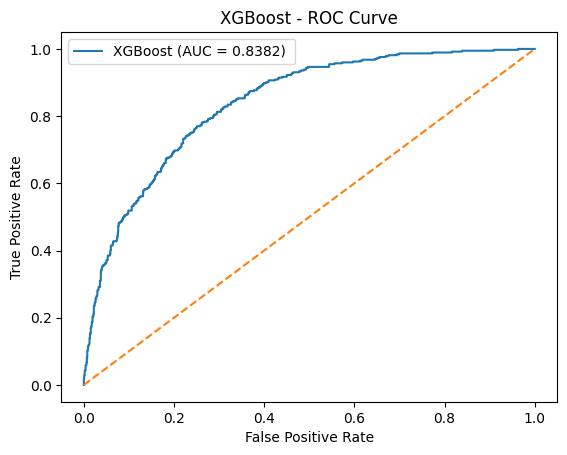

In [76]:
xgb_results = evaluate_classifier(xgb_model,X_test,y_test, title = 'XGBoost')

In [79]:
print('AUC Comparison')
print(f"Logistic Regression AUC: {baseline_results['auc']:.4f} ")
print(f"XGboost AUC: {xgb_results['auc']:.4f} ")
print("/nConfusion Matrix (TN,FP,FN,TP)")
print('LogReg:', baseline_results['cm'].ravel())
print('XGBoost:', xgb_results['cm'].ravel())

AUC Comparison
Logistic Regression AUC: 0.8413 
XGboost AUC: 0.8382 
/nConfusion Matrix (TN,FP,FN,TP)
LogReg: [747 288  81 293]
XGBoost: [932 103 180 194]


In [80]:
ohe = xgb_pipe.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']

In [81]:
cat_feature_names = ohe.get_feature_names_out(cat_cols)

In [82]:
feature_names = np.concatenate([num_cols, cat_feature_names])

In [84]:
importances = xgb_model.named_steps['clf'].feature_importances_

In [85]:
top_n = 15

In [86]:
idx = np.argsort(importances)[-top_n:]

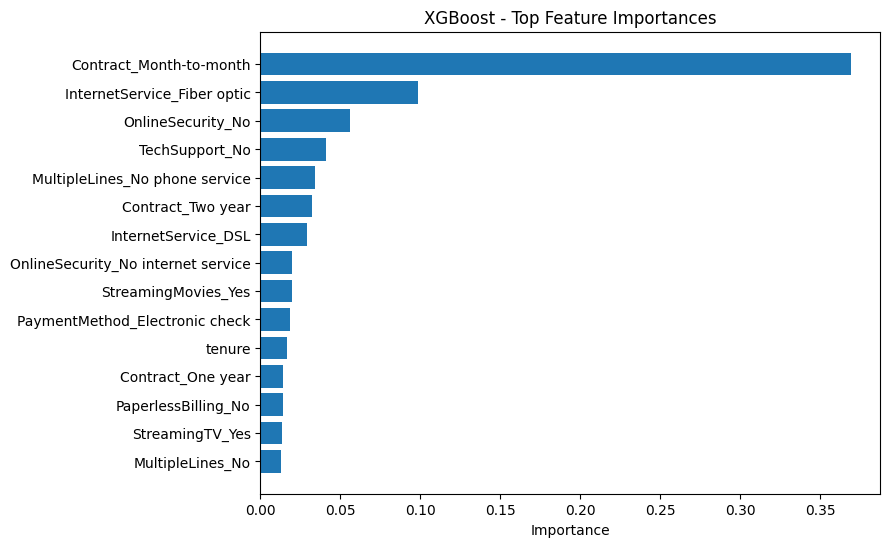

In [87]:
plt.figure(figsize = (8,6))
plt.barh(feature_names[idx], importances[idx])
plt.title('XGBoost - Top Feature Importances')
plt.xlabel('Importance')
plt.show()

In [88]:
xgb_proba = xgb_model.predict_proba(X_test)[:,1]

In [91]:
prec, rec, thr = precision_recall_curve(y_test,xgb_proba)

In [92]:
ap = average_precision_score(y_test, xgb_proba)

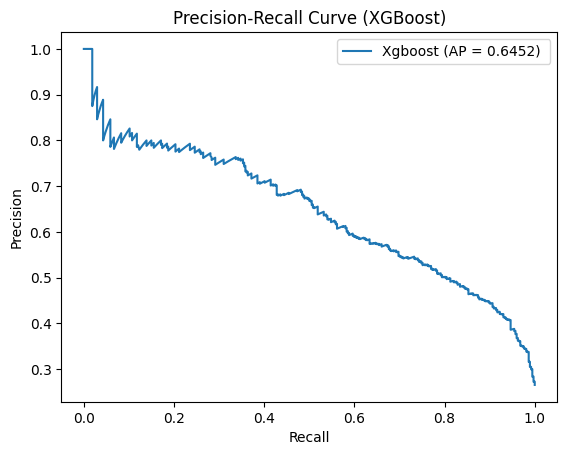

In [93]:
plt.figure()
plt.plot(rec,prec,label=f"Xgboost (AP = {ap:.4f}) ")
plt.xlabel("Recall")
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend()
plt.show()

In [94]:
print('Threshold count:', len(thr))

Threshold count: 1405


In [95]:
print('Precision/Recall points:', len(prec), len(rec))

Precision/Recall points: 1406 1406


In [96]:
target_recall = 0.75

In [97]:
best_idx = None

In [98]:
best_precision = -1

In [99]:
for i in range(len(thr)):
    if rec[i] >= target_recall and prec[i] > best_precision:
        best_precision = prec[i]
        best_idx = i

In [100]:
if best_idx is None:
    print(f"Target recall{target_recall} not reeached. Try lowering the target. ")
else:
    best_thr = thr[best_idx]
    print(f"Selected Threshold: {best_thr:.4f} ")
    print(f"Precision at threshold {prec[best_idx]:.4f}")
    print(f"Recall at threshold: {rec[best_idx]:.4f} ")
    

Selected Threshold: 0.2970 
Precision at threshold 0.5322
Recall at threshold: 0.7513 


In [101]:
y_pred_thr = (xgb_proba >= best_thr).astype(int)

In [103]:
cm_thr = confusion_matrix(y_test,y_pred_thr)

In [104]:
tn,fp,fn,tp = cm_thr.ravel()

In [105]:
print('Confusion Matirx @ tuned threshold (TN,FP,FN,TP):')
print(tn,fp,fn,tp)

Confusion Matirx @ tuned threshold (TN,FP,FN,TP):
788 247 93 281


In [106]:
log_proba = model.predict_proba(X_test)[:,1]

In [107]:
y_pred_log = (log_proba >=0.5).astype(int)

In [108]:
cm_log = confusion_matrix(y_test,y_pred_log)

In [109]:
print("\nBaseline LogReg CM @0.5:", cm_log.ravel())


Baseline LogReg CM @0.5: [747 288  81 293]


In [112]:
print('Tuned XGB CM', cm_thr.ravel())

Tuned XGB CM [788 247  93 281]


In [113]:
FN_COST = 5

In [114]:
FP_COST = 1

In [115]:
def cost_for_threshold(y_true,proba,threshold,fn_cost = 5, fp_cost=1):
    y_hat = (proba>= threshold).astype(int)
    tn,fp,fn,tp = confusion_matrix(y_true,y_hat).ravel()
    return fn * fn_cost + fp * fp_cost, (tn,fp,fn,tp)
    

In [116]:
thresholds = np.linspace(0.05,.095,181)

In [117]:
best = {'thr':None, 'cost':float('inf'), 'cm':None}

In [118]:
for t in thresholds:
    c,cm = cost_for_threshold(y_test,xgb_proba,t,FN_COST,FP_COST)
    if c < best['cost']:
        best['cost'] = c
        best['thr'] = t
        best['cm'] = cm

In [119]:
print(f"Best threshold by cost : {best['thr']:.2f} ")

Best threshold by cost : 0.08 


In [120]:
print(f"Best cost: {best['cost']} ")

Best cost: 615 


In [121]:
print('CM (TN,FP,FN,TP):', best['cm'])

CM (TN,FP,FN,TP): (np.int64(520), np.int64(515), np.int64(20), np.int64(354))


## Final Decision (Day 11)

- Baseline Logistic Regression (threshold=0.50) achieved strong churn recall with higher false positives.
- XGBoost at threshold=0.50 reduced false positives but missed too many churn customers.
- After threshold tuning (threshold=0.297, target recall≥0.75), XGBoost achieved a business-aligned trade-off.

**Chosen approach:** XGBoost with tuned threshold (0.297) when the business cost of missing churn is high.